In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

### This week, I worked on optimizing the patching code even more:
#### I pulled five patches and an overall image of the scan 
#### I centered both scans based on the scan center of mass in order to ensure that the patches were as comparable as possible
#### I found patches based on the optimizing the average contour of both scans rather than the max contour of melana


### rotating tif masks

In [2]:
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(blurred, kernel, iterations=1)
    cleaned_edges = cv2.erode(dilated, kernel, iterations=1)
    return cleaned_edges

# Find the largest contour by area
def find_largest_contour(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

# Fill a contour to create a mask of the shape
def fill_contour(img_shape, contour):
    mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

# Calculate the center of mass of a filled contour
def get_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = mask.shape[1] // 2, mask.shape[0] // 2  # Default to center if no mass
    return cX, cY

# Center the image based on center of mass
def center_image(mask):
    cX, cY = get_center_of_mass(mask)
    shiftX = mask.shape[1] // 2 - cX
    shiftY = mask.shape[0] // 2 - cY
    translation_matrix = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    centered_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))
    return centered_mask

# Combines the above functions for the pipeline
def pipeline_helper(tif_path):
    image = cv2.imread(tif_path, 0)
    edges = cv2.Canny(image, 50, 100)
    cleaned_edges = clean_edges(edges)
    contours, _ = cv2.findContours(cleaned_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = find_largest_contour(contours)
    mask = fill_contour(cleaned_edges.shape, largest_contour)
    centered_mask = center_image(mask)
    return centered_mask

In [3]:
# Rotate the image around its center
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated_image

# Pad an image symmetrically to match the target size
def pad_to_size(image, target_size):
    h, w = image.shape[:2]
    pad_top = (target_size[1] - h) // 2
    pad_bottom = target_size[1] - h - pad_top
    pad_left = (target_size[0] - w) // 2
    pad_right = target_size[0] - w - pad_left
    padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)
    return padded_image


In [4]:
# Mirror the image either horizontally or vertically
def mirror_image(image, direction='horizontal'):
    if direction == 'horizontal':
        mirrored_image = cv2.flip(image, 1)  # Horizontal flip
    elif direction == 'vertical':
        mirrored_image = cv2.flip(image, 0)  # Vertical flip
    else:
        raise ValueError("Direction should be either 'horizontal' or 'vertical'")
    return mirrored_image

# Function to find the optimal rotation and flip for alignment
def find_best_rotation_with_flip(mask1, mask2, angles=np.arange(-90, 91, 1)):
    best_overlap = 0
    best_angle = 0
    best_flip = None

    for flip in [None, 'horizontal', 'vertical']:
        flipped_mask2 = mirror_image(mask2, flip) if flip else mask2
        for angle in angles:
            rotated_mask2 = rotate_image(flipped_mask2, angle)
            intersection = cv2.bitwise_and(mask1, rotated_mask2)
            union = cv2.bitwise_or(mask1, rotated_mask2)
            similarity_score = np.sum(intersection) / np.sum(union)

            if similarity_score > best_overlap:
                best_overlap = similarity_score
                best_angle = angle
                best_flip = flip

    return best_overlap, best_angle, best_flip


In [5]:
# Main pipeline with optimal flip function
def pipeline_with_optimal_flip(path1, path2):
    mask1 = pipeline_helper(path1)
    mask2 = pipeline_helper(path2)

    # Step 1: Get maximum width and height to resize all three images
    max_width = max(mask1.shape[1], mask2.shape[1])
    max_height = max(mask1.shape[0], mask2.shape[0])

    # Step 2: Resize and pad all masks to the same size
    mask1 = pad_to_size(mask1, (max_width, max_height))
    mask2 = pad_to_size(mask2, (max_width, max_height))

    # Step 3: Find the best rotation and flip for mask2 that maximizes overlap with mask1
    best_overlap_2, angle2, flip2 = find_best_rotation_with_flip(mask1, mask2)
    mask2_flipped = mirror_image(mask2, flip2) if flip2 else mask2
    mask2_transformed = rotate_image(mask2_flipped, angle2)

    return mask1, mask2, mask2_transformed, angle2, flip2


In [6]:
paths = ['patient1/h1810898A mela_ROI_1.tif', 'patient1/h1810898A sox10_ROI_1.tif']

melana, sox, sox_rotated, angle2, flip2 = pipeline_with_optimal_flip(paths[0], paths[1])

In [7]:
# Create a 3x3 kernel for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

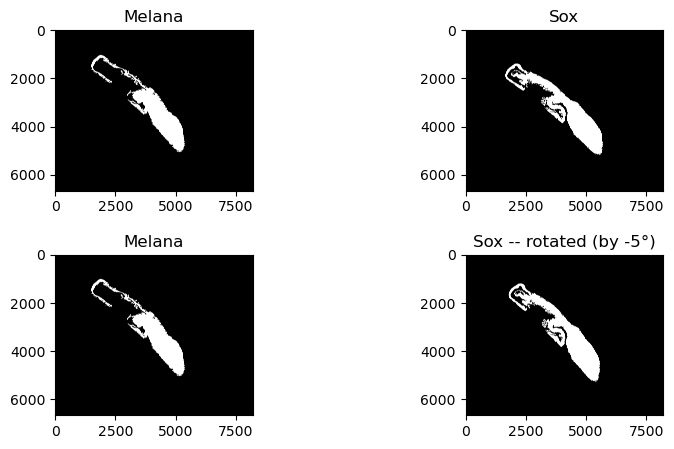

In [9]:
plt.figure(figsize=(15, 5))

# Original images
plt.subplot(2, 3, 2)
plt.title('Melana')
plt.imshow(melana, cmap='gray')

plt.subplot(2, 3, 3)
plt.title('Sox')
plt.imshow(sox, cmap='gray')

# Transformed images with rotation and flip information
plt.subplot(2, 3, 5)
plt.title('Melana')
plt.imshow(melana, cmap='gray')

# Show rotation and flip information for Sox
sox_flip_info = f", flipped {flip2}" if flip2 else ""
plt.subplot(2, 3, 6)
plt.title(f'Sox -- rotated (by {angle2}°{sox_flip_info})')
plt.imshow(sox_rotated, cmap='gray')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

plt.show()


### My patching code (Updated)

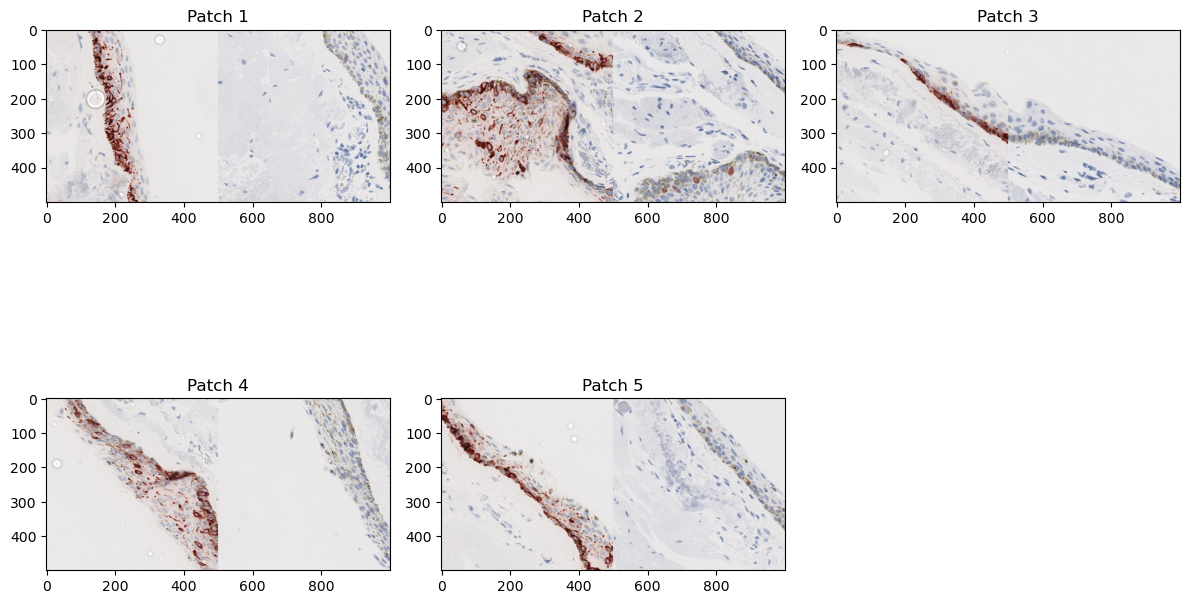

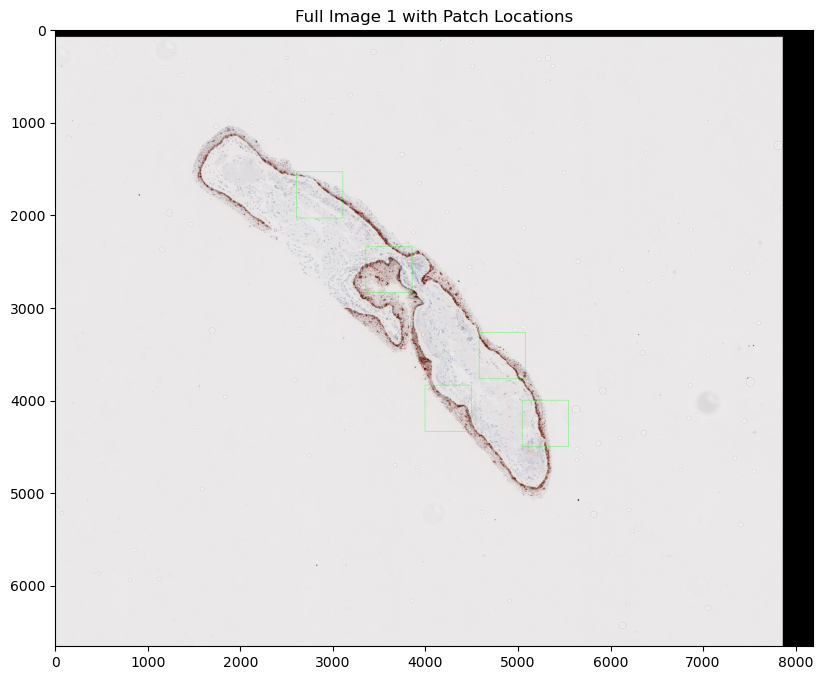

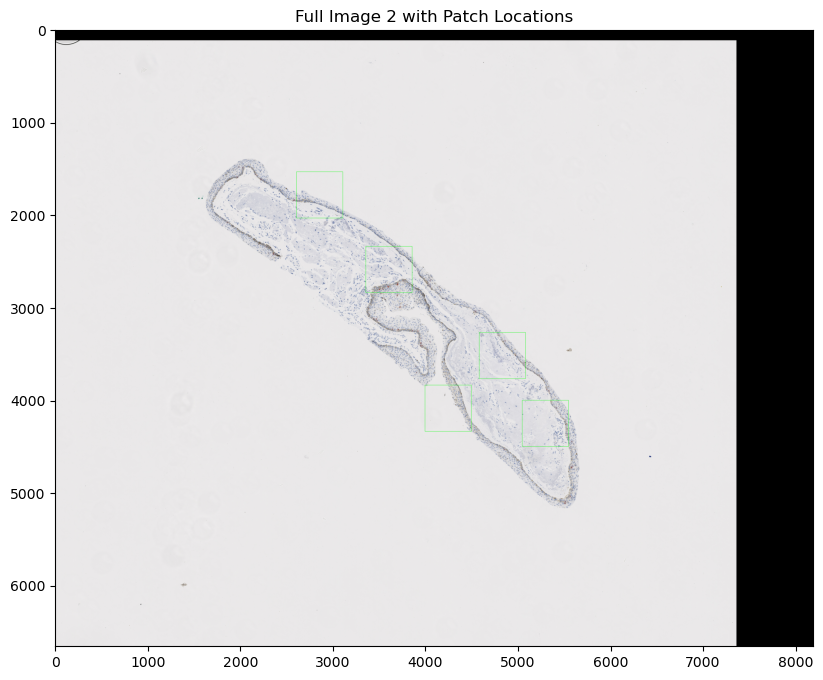

In [86]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(blurred, kernel, iterations=1)
    cleaned_edges = cv2.erode(dilated, kernel, iterations=1)
    return cleaned_edges

def find_largest_contour(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

def calculate_center_of_mass(image):
    moments = cv2.moments(image)
    cX = int(moments["m10"] / moments["m00"])
    cY = int(moments["m01"] / moments["m00"])
    return cX, cY

def translate_image(image, translation_vector):
    rows, cols = image.shape[:2]
    translation_matrix = np.float32([[1, 0, translation_vector[0]], [0, 1, translation_vector[1]]])
    translated_image = cv2.warpAffine(image, translation_matrix, (cols, rows))
    return translated_image

def get_random_non_overlapping_point(contour, patch_size, image_shape, existing_patches):
    contour_mask = np.zeros(image_shape[:2], dtype=np.uint8)
    cv2.drawContours(contour_mask, [contour], -1, 255, thickness=cv2.FILLED)
    y_coords, x_coords = np.where(contour_mask == 255)
    while True:
        random_index = random.randint(0, len(x_coords) - 1)
        center_x, center_y = x_coords[random_index], y_coords[random_index]
        start_x = center_x - patch_size[0] // 2
        start_y = center_y - patch_size[1] // 2
        if (start_x >= 0 and start_y >= 0 and
            start_x + patch_size[0] <= image_shape[1] and start_y + patch_size[1] <= image_shape[0]):
            overlap = False
            for (ex, ey) in existing_patches:
                if (ex < start_x + patch_size[0] and ex + patch_size[0] > start_x and
                    ey < start_y + patch_size[1] and ey + patch_size[1] > start_y):
                    overlap = True
                    break
            if not overlap:
                return start_x, start_y

def extract_patch(image, start_x, start_y, patch_size):
    return image[start_y:start_y+patch_size[1], start_x:start_x+patch_size[0]]

def extract_patches_from_images(paths, patch_size=(500, 500), num_patches=5, num_attempts=20):
    images = [cv2.imread(path) for path in paths]

    # Calculate center of mass for each image
    com_images = []
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 100)
        cleaned_edges = clean_edges(edges)
        contours, _ = cv2.findContours(cleaned_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = find_largest_contour(contours)
        contour_mask = np.zeros_like(gray)
        cv2.drawContours(contour_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        cX, cY = calculate_center_of_mass(contour_mask)
        
        # Translate image so the center of mass is at the center of the image
        translation_vector = (gray.shape[1] // 2 - cX, gray.shape[0] // 2 - cY)
        com_image = translate_image(image, translation_vector)
        com_images.append(com_image)

    patches = []
    patch_coords = []
    existing_patches = []
    for _ in range(num_patches):
        for _ in range(num_attempts):
            try:
                # Extract contours from both images
                edges1 = cv2.Canny(com_images[0], 50, 100)
                cleaned_edges1 = clean_edges(edges1)
                contours1, _ = cv2.findContours(cleaned_edges1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                largest_contour1 = find_largest_contour(contours1)

                edges2 = cv2.Canny(com_images[1], 50, 100)
                cleaned_edges2 = clean_edges(edges2)
                contours2, _ = cv2.findContours(cleaned_edges2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                largest_contour2 = find_largest_contour(contours2)
                
                # Find random non-overlapping point
                start_x, start_y = get_random_non_overlapping_point(largest_contour1, patch_size, com_images[0].shape, existing_patches)
                
                # Extract patches
                patch1 = extract_patch(com_images[0], start_x, start_y, patch_size)
                patch2 = extract_patch(com_images[1], start_x, start_y, patch_size)
                
                # Calculate average contour area
                avg_contour_area = (cv2.contourArea(largest_contour1) + cv2.contourArea(largest_contour2)) / 2
                
                # Append patch only if it meets the average contour area criteria
                if avg_contour_area > threshold:
                    patches.append([patch1, patch2])
                    patch_coords.append((start_x, start_y))
                    existing_patches.append((start_x, start_y))
                break
            except:
                continue

    if len(patches) < num_patches:
        raise ValueError(f"Could not find {num_patches} valid patches after several attempts.")

    return patches, patch_coords, com_images, patch_size

# Example paths
paths = ['patient1/h1810898A mela_ROI_1.tif', 'patient1/h1810898A sox10_ROI_1.tif']

# Set a threshold for the average contour area
threshold = 1000  # You can adjust this value based on your specific needs

# Extract patches from images
patches, patch_coords, images, patch_size = extract_patches_from_images(paths, num_patches=5)

# Visualize the patches extracted from the images
plt.figure(figsize=(12, 8))
patch_titles = [f'Patch {i+1}' for i in range(len(patches))]
for i, patch_set in enumerate(patches):
    plt.subplot(2, 3, i + 1)
    combined_patch = np.concatenate(patch_set, axis=1)
    plt.imshow(cv2.cvtColor(combined_patch, cv2.COLOR_BGR2RGB))
    plt.title(patch_titles[i])
plt.tight_layout()
plt.show()

# Visualize the full images with the patch locations
for img_index, img in enumerate(images):
    plt.figure(figsize=(10, 8))
    img_with_patches = img.copy()
    for (start_x, start_y) in patch_coords:
        cv2.rectangle(img_with_patches, (start_x, start_y), (start_x+patch_size[0], start_y+patch_size[1]), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(img_with_patches, cv2.COLOR_BGR2RGB))
    plt.title(f'Full Image {img_index+1} with Patch Locations')
    plt.show()
